# Information spread and influence Maximization in social networks


In this notebook we will explore the network of Game of Thrones characters and simulate information spread and influence maximization in the network.

In [85]:
%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
from collections import Counter
import sys
import os
plt.rcParams["figure.figsize"] = (20,10)
import tqdm as tqdm

warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Game of thrones network

![](images/got.png)

Andrew J. Beveridge, an associate professor of mathematics at Macalester College, and Jie Shan, an undergraduate created a network from the book A Storm of Swords by extracting relationships between characters to find out the most important characters in the book(or GoT).

The dataset is publicly avaiable for the 5 books at https://github.com/mathbeveridge/asoiaf. This is an interaction network and were created by connecting two characters whenever their names (or nicknames) appeared within 15 words of one another in one of the books. The edge weight corresponds to the number of interactions.

Credits:

Blog: https://networkofthrones.wordpress.com

Math Horizons Article: https://www.maa.org/sites/default/files/pdf/Mathhorizons/NetworkofThrones%20%281%29.pdf

Mridul Seth: https://github.com/MridulS/pydata-networkx/


##### Let's load in the datasets

In [86]:
import pandas as pd
books = []
for i in range(2):
    books.append(pd.read_csv('data/SN{}-edges.csv'.format(i+1)))

In [87]:
all_books = pd.concat(books)

In [88]:
all_books.head()

,Source,Target,Type,weight,place
0,Georgiana-Sala,Stefan-Leonte,Undirected,3,1.0
1,Georgiana-Sala,Timon-Lascu,Undirected,6,1.0
2,Natalia-Constantin,Veronica-Matei,Undirected,5,1.0
3,Natalia-Constantin,Mihai-Constantin,Undirected,4,1.0
4,Isabela-Lupu,Sabina-Petran,Undirected,4,1.0


### we will sum all the books into a single edge between characters

In [89]:
edges = all_books.groupby(['Source','Target']).agg({'weight':'sum'}).reset_index()

In [90]:
edges.sort_values('weight',ascending=False).head()

,Source,Target,weight
776,Mihai-Constantin,Robert-Antonescu,317
628,Marcian-Manole,Sorina-Sicoe,163
75,Astrid-Dragan,Corina-Filip,144
685,Marius-Cojocaru,Luiza-Dinu,140
210,Corina-Filip,Samuel-Tudose,133


In [91]:
import networkx as nx
GOT = nx.from_pandas_edgelist(edges, 
                            source='Source',
                            target='Target',
                            edge_attr='weight' )

In [92]:
print(nx.info(GOT))

Name: 
Type: Graph
Number of nodes: 362
Number of edges: 1250
Average degree:   6.9061


In [93]:
weighted_degrees = dict(nx.degree(GOT,weight='weight'))
max_degree = max(weighted_degrees.values())

In [94]:
import seaborn as sns

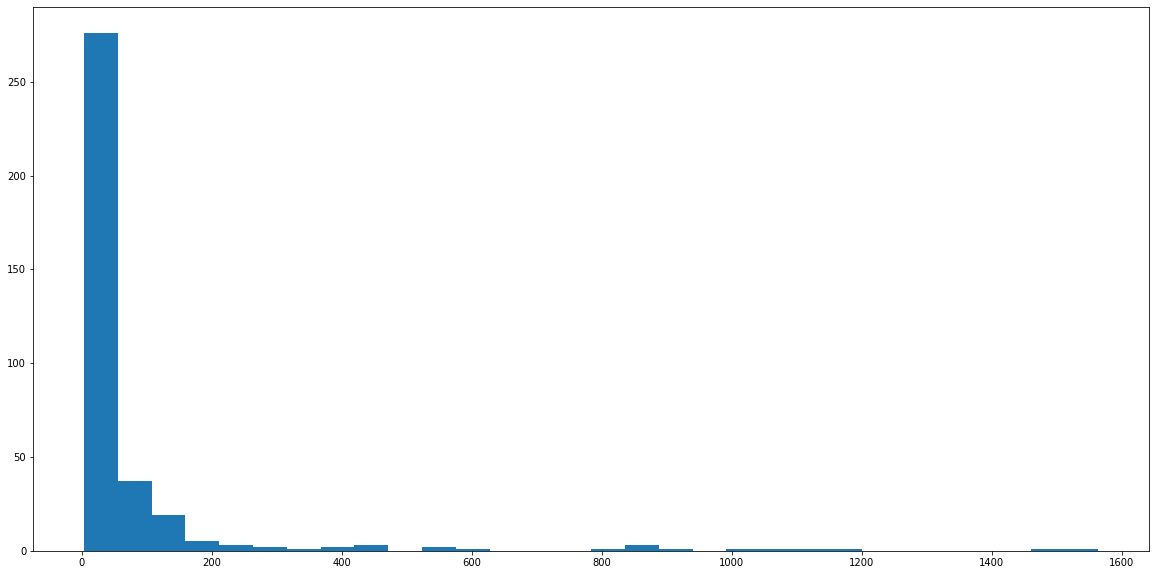

In [95]:
import matplotlib.pyplot as plt
h = plt.hist(weighted_degrees.values(), bins = 30)

### Let's focus on the subnetwork of the key characters:

In [96]:
subG = GOT.subgraph([n for n in weighted_degrees if weighted_degrees[n]>200])

In [97]:
print(nx.info(subG))

Name: 
Type: Graph
Number of nodes: 26
Number of edges: 180
Average degree:  13.8462


In [98]:
pos = nx.spring_layout(subG,weight='weight',iterations=20, k = 4)

Plot the network:

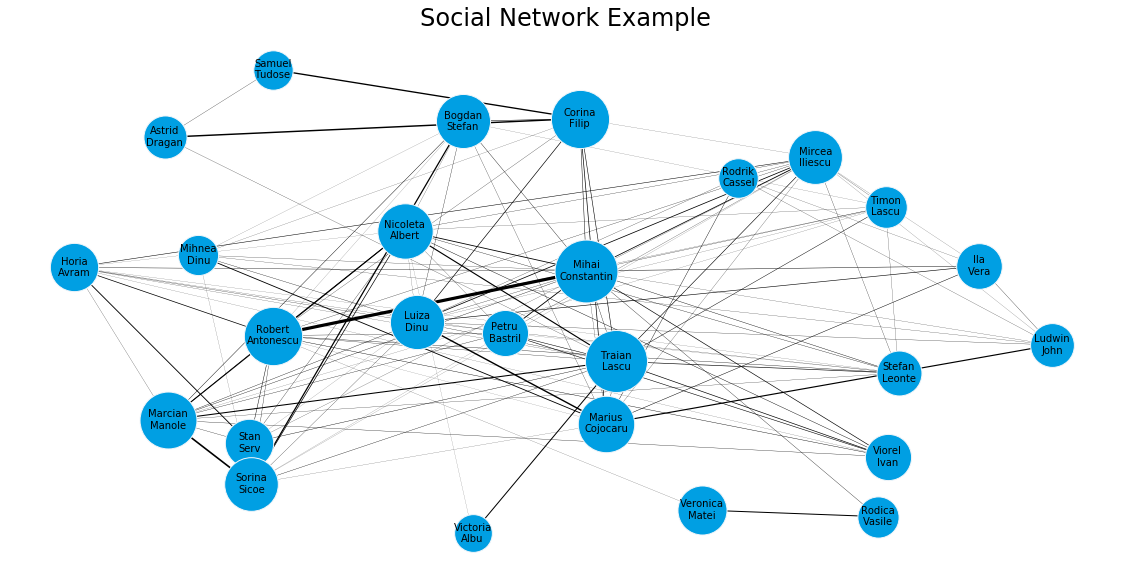

In [99]:
plt.rcParams["figure.figsize"] = (20,10)
import tqdm as tqdm
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
plt.axis('off')
plt.title('Social Network Example',fontsize = 24)


for node in subG.nodes():
    size = 100*weighted_degrees[node]**0.5
    ns = nx.draw_networkx_nodes(subG,pos,nodelist=[node], node_size=size, node_color='#009fe3')
    ns.set_edgecolor('#f2f6fa')

nx.draw_networkx_labels(subG,pos,{n:n.replace('-','\n') for n in subG.nodes() if weighted_degrees[n]>100},font_size=10);

for e in subG.edges(data=True):
    if e[2]['weight']>10:
        nx.draw_networkx_edges(subG,pos,[e],width=e[2]['weight']/100,edge_color='black')

(-0.8041578993426551,
 1.0990327314920478,
 -0.7253057016562484,
 0.6390327727255195)

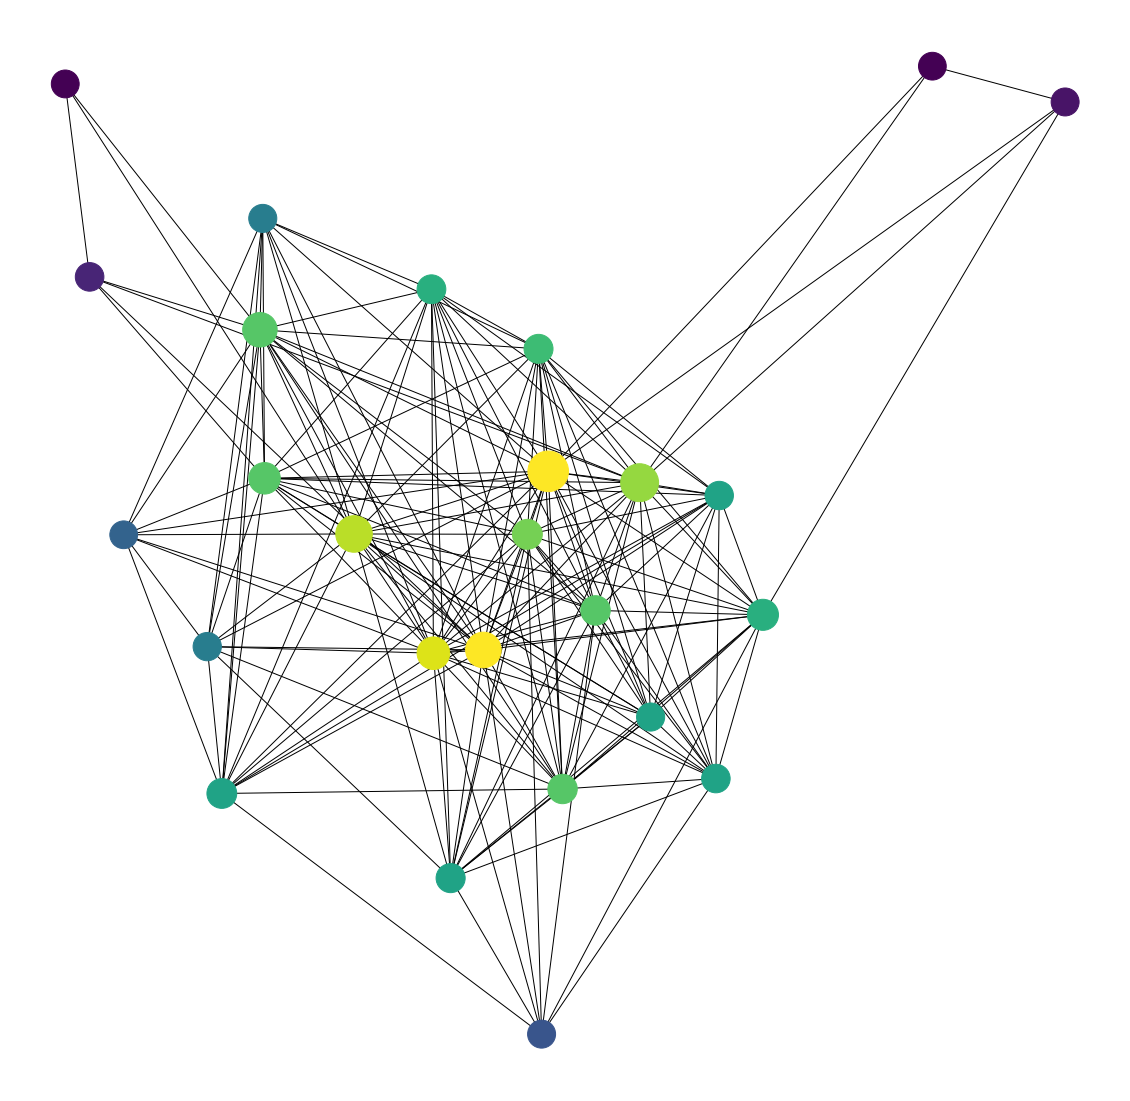

In [100]:
pos = nx.spring_layout(subG)
betCent = nx.betweenness_centrality(subG, normalized=True, endpoints=True)
node_color = [20000.0 * subG.degree(v) for v in subG]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(subG, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

In [101]:
sorted(betCent, key=betCent.get, reverse=True)[:5]

['Mihai-Constantin',
 'Robert-Antonescu',
 'Luiza-Dinu',
 'Traian-Lascu',
 'Corina-Filip']

In [102]:
degCent = nx.degree_centrality(subG)
sorted(degCent, key=degCent.get, reverse=True)[:5]

['Traian-Lascu',
 'Mihai-Constantin',
 'Mircea-Iliescu',
 'Luiza-Dinu',
 'Robert-Antonescu']

In [103]:
eigCent = nx.eigenvector_centrality(subG)
sorted(eigCent, key=eigCent.get, reverse=True)[:5]

['Traian-Lascu',
 'Mircea-Iliescu',
 'Mihai-Constantin',
 'Luiza-Dinu',
 'Marcian-Manole']

In [104]:
infection_times = {}

### Simulate independent cascade:

In [41]:
def independent_cascade(G,t,infection_times):
    #doing a t->t+1 step of independent_cascade simulation
    #each infectious node infects neigbors with probabilty proportional to the weight
    max_weight = max([e[2]['weight'] for e in G.edges(data=True)])
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    for n in current_infectious:
        for v in G.neighbors(n):
            if v not in infection_times:
                if  G.get_edge_data(n,v)['weight'] >= np.random.random()*max_weight:
                    infection_times[v] = t+1
    return infection_times

In [42]:
def plot_G(G,pos,infection_times,t):
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    plt.figure()
    plt.axis('off')
    plt.title('Information Diffusion, t={}'.format(t),fontsize = 24)

    for node in G.nodes():
        size = 100*weighted_degrees[node]**0.5
        if node in current_infectious:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#feba02')
        elif infection_times.get(node,9999999)<t:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#f2f6fa')
        else:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#009fe3')
        ns.set_edgecolor('#f2f6fa')
    nx.draw_networkx_labels(G,pos,{n:n.replace('-','\n') for n in G.nodes() if weighted_degrees[n]>100},font_size=10);

    for e in G.edges(data=True):
        if e[2]['weight']>10:
            nx.draw_networkx_edges(G,pos,[e],width=e[2]['weight']/100,edge_color='#707070')


### Suppose Bran and Sam told Jon a secret. Who will find out about it?

In [43]:
infection_times = {'Traian-Lascu':-1,'Corina-Filip':0}

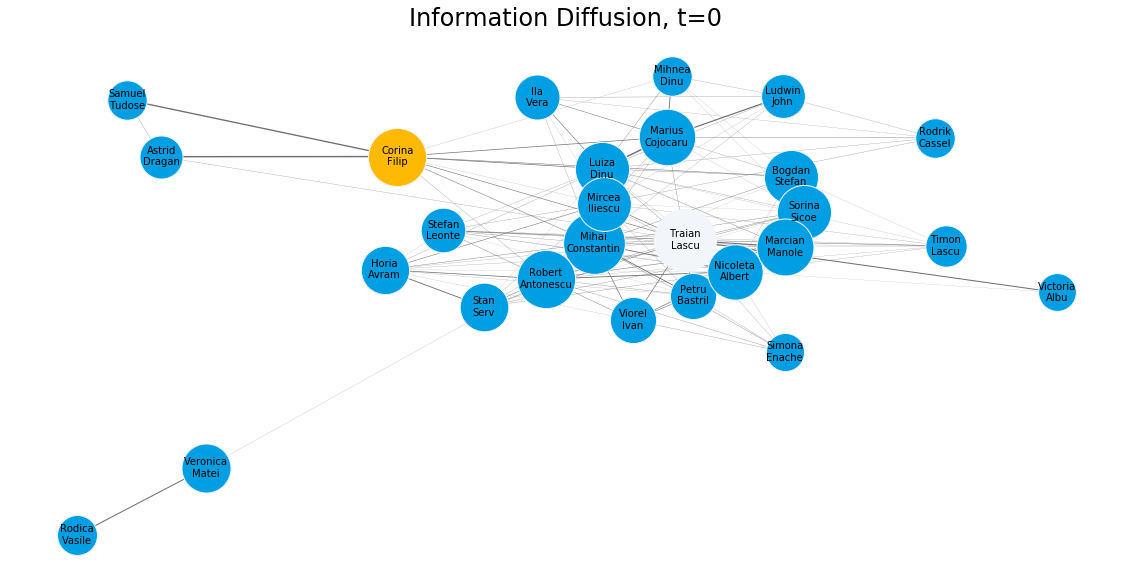

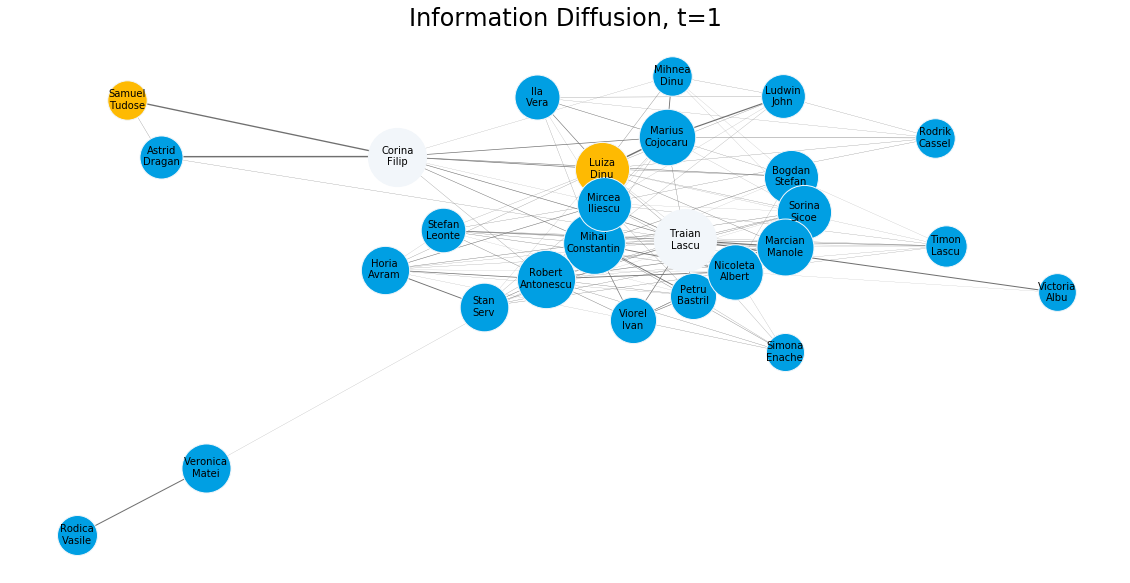

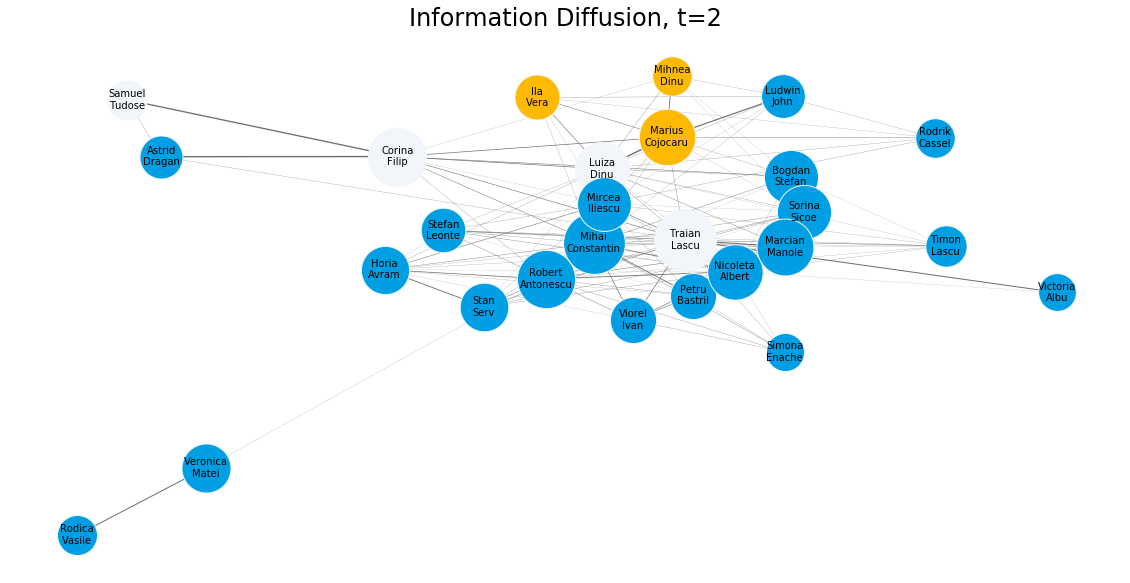

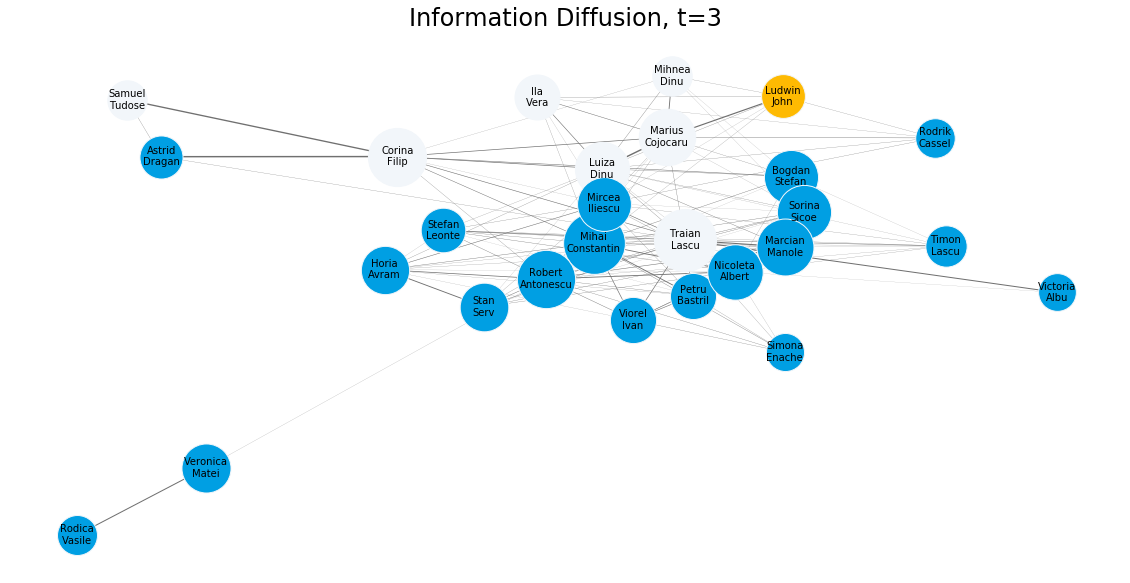

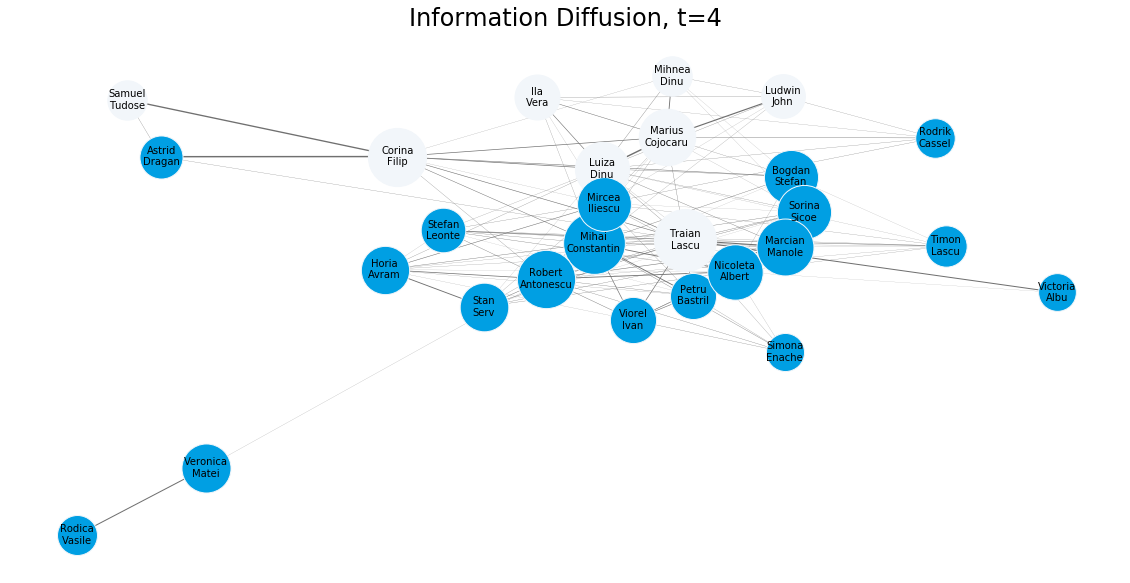

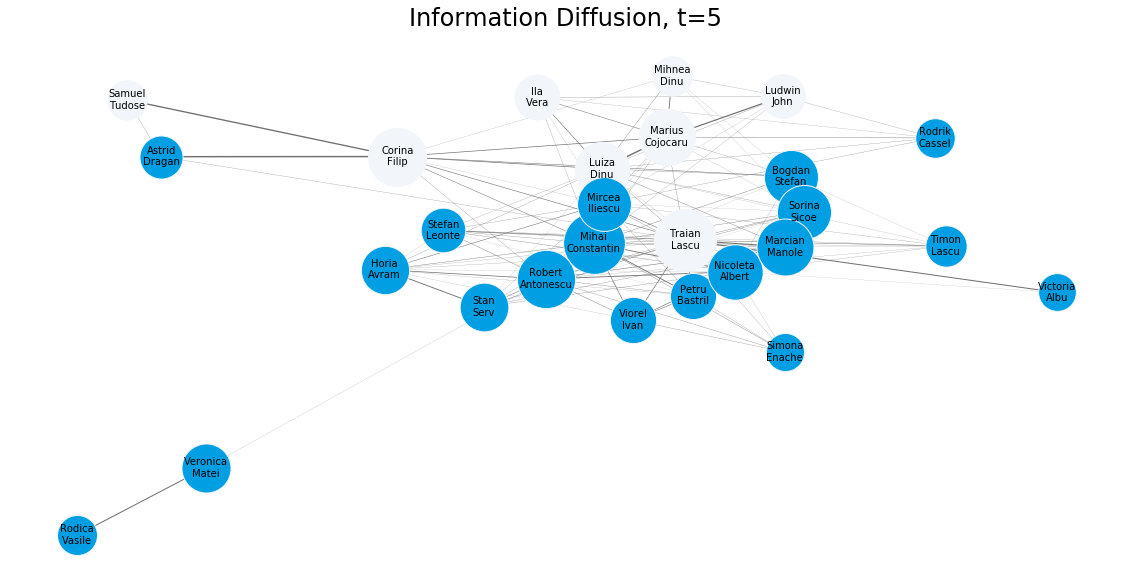

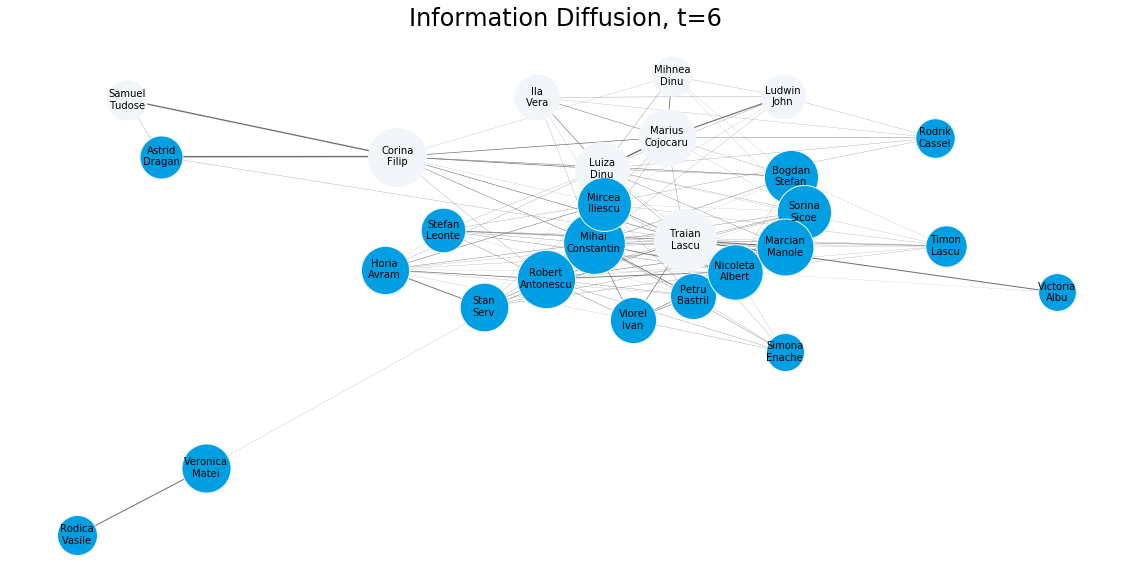

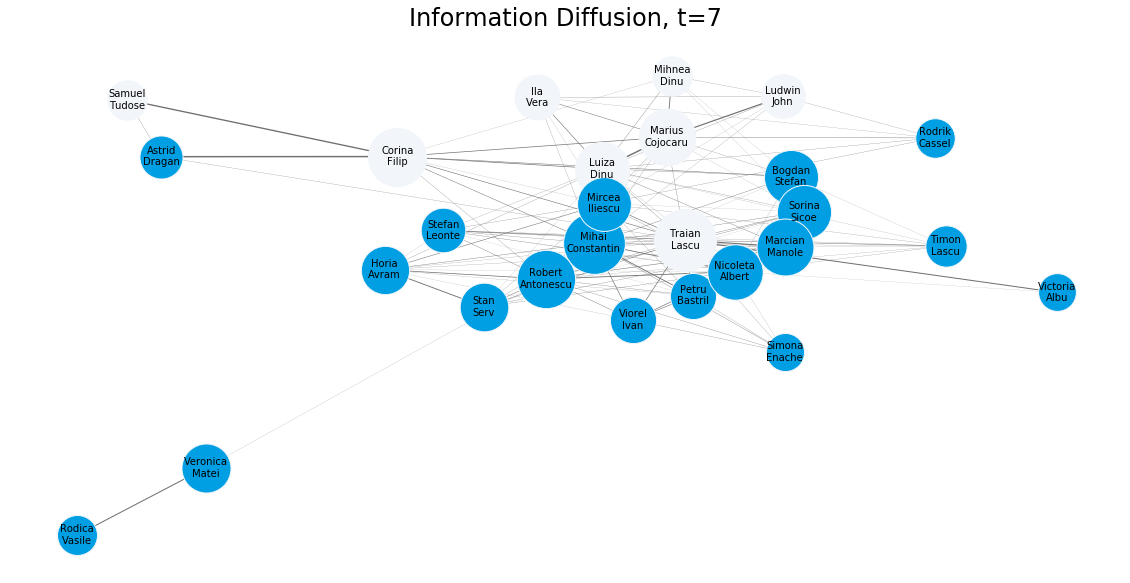

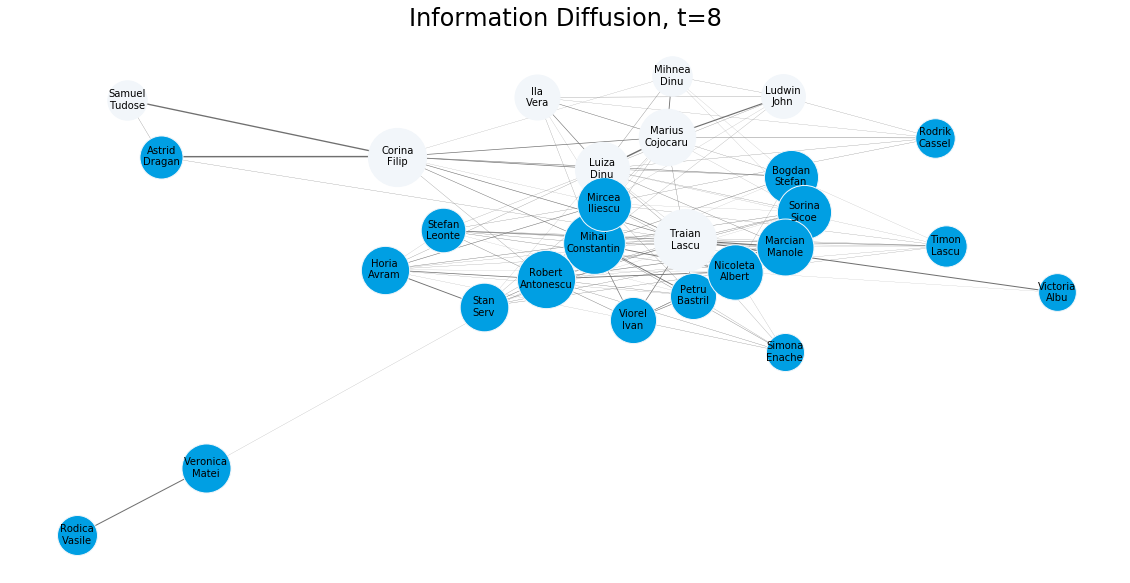

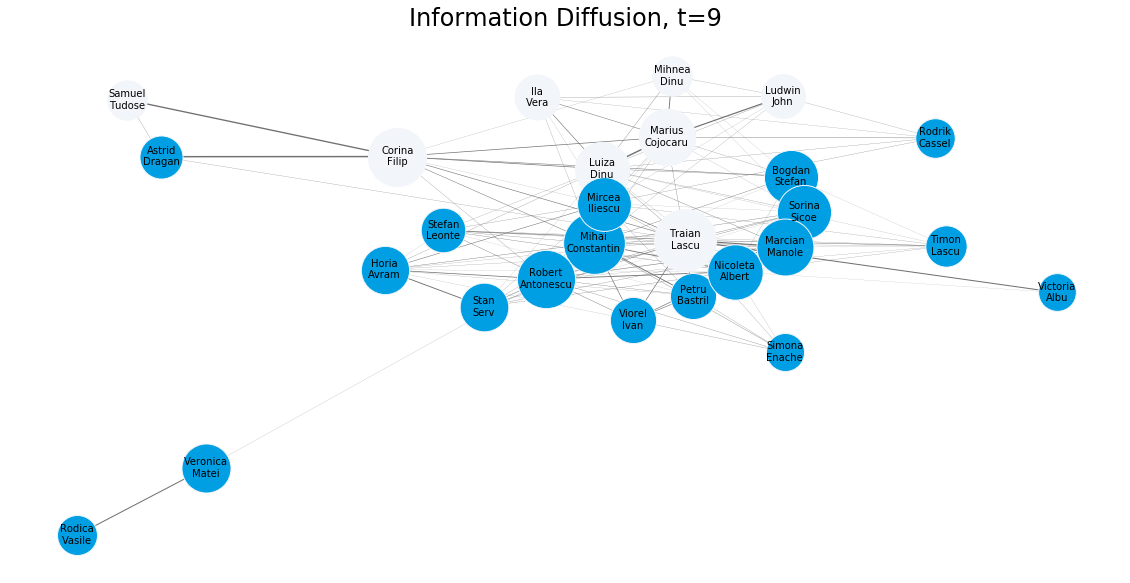

In [44]:
import numpy as np
for t in range(10):
    plot_G(subG,pos,infection_times,t)
    infection_times = independent_cascade(subG,t,infection_times)

#### Let's identify infuencers in the networkm

In [ ]:
top = pd.DataFrame.from_dict(dict(nx.degree(subG)),orient='index').sort_values(0,ascending=False)
top.columns = ['Degree']
top['Weighted Degree'] =  pd.DataFrame.from_dict(dict(nx.degree(subG,weight='weight')),orient='index')
top['PageRank'] = pd.DataFrame.from_dict(dict(nx.pagerank_numpy(subG,weight='weight')),orient='index')
top['Betweenness'] =  pd.DataFrame.from_dict(dict(nx.betweenness_centrality(subG,weight='weight')),orient='index')

In [ ]:
top.head()

In [ ]:
methods = top.columns

print(nx.info(subG))
print(nx.info(GOT))

### For different budgets lets compare the centrality metrics for seeding

In [ ]:
max_budget = len(subG.nodes())
trials = 50
all_results = []
for budget in tqdm.tqdm_notebook(range(max_budget)):
    results = {'budget':budget}
    for method in methods:
        infections = []
        for i in range(trials):
            infected = 0
            t= 0
            infection_times = {n:0 for n in top.sort_values(method,ascending=False).index[:budget]}
            while len(infection_times)>infected:
                #t+=1
                infected = len(infection_times)
                infection_times = independent_cascade(subG,t,infection_times)
                t+=1
            infections.append(infected)
        results[method] = np.round(np.mean(infections)/len(subG.nodes()),2)

    all_results.append(results)
              

In [ ]:
res_df = pd.concat([pd.DataFrame.from_dict(r,orient='index').T 
                        for r in all_results]).set_index('budget')

In [ ]:
res_df.index = res_df.index/len(subG.nodes())

In [ ]:
res_df.head()

### Now we'll compare the methods on a plot (percentage of infected network)

In [ ]:
res_df.plot()
plt.legend(fontsize = 18)
plt.ylabel('Virality rate (out of total graph size)',fontsize = 18)
plt.xlabel('Seeding Budget (out of graph size)', fontsize = 18)

### Let's find the best seeding 'couple' (budget = 2) by bruteforce search

In [ ]:
from itertools import product

budget=2

seed_sets = list(product(*[subG.nodes()]*budget))

print(len(seed_sets),'Seeding options')

In [3]:
import tqdm as tqdm
budget = 2
trials = 20
all_results = []
results = {'budget':budget}
for seed in tqdm.tqdm_notebook(seed_sets[:]):
    infections = []
    for i in range(trials):
        infected = 0
        t= 0
        infection_times = {n:0 for n in seed}
        while len(infection_times)>infected:
            #t+=1
            infected = len(infection_times)
            infection_times = independent_cascade(subG,t,infection_times)
            t+=1
        infections.append(infected)
    results[seed] = np.round(np.mean(infections)/len(subG.nodes()),2)

all_results.append(results)

NameError: name 'seed_sets' is not defined

In [4]:
sorted(results.items(), key = lambda x: x[1], reverse=True)[:10]

[('budget', 2)]